In [124]:
# https://tinygp.readthedocs.io/en/stable/tutorials/modeling.html

In [125]:
import matplotlib.pyplot as plt
plt.figure()
plt.show()
plt.close()
plt.rcParams.update({'font.size':16})

<Figure size 432x288 with 0 Axes>

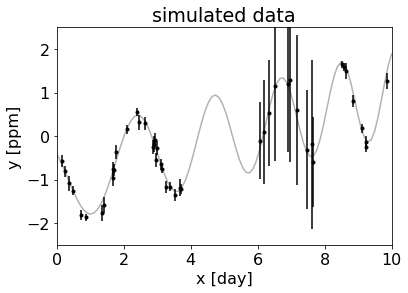

In [126]:
import numpy as np


random = np.random.default_rng(42)

t = np.sort(
    np.append(
        random.uniform(0, 3.8, 28),
        random.uniform(5.5, 10, 18),
    )
)
yerr = random.uniform(0.08, 0.22, len(t))
y = (
    0.2 * (t - 5)
    + np.sin(3 * t + 0.1 * (t - 5) ** 2)
    + yerr * random.normal(size=len(t))
)

# enlarge some error bars for testing
yerr[(t > 6) & (t < 8)] = yerr[(t > 6) & (t < 8)]*10

true_t = np.linspace(0, 10, 100)
true_y = 0.2 * (true_t - 5) + np.sin(3 * true_t + 0.1 * (true_t - 5) ** 2)

plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("x [day]")
plt.ylabel("y [ppm]")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5)
_ = plt.title("simulated data")

In [127]:
from tinygp import kernels, GaussianProcess

import jax
import jax.numpy as jnp

import flax.linen as nn
from flax.linen.initializers import zeros

import optax


class GPModule(nn.Module):
    @nn.compact
    def __call__(self, x, yerr, y, t):
        mean = self.param("mean", zeros, ())
        log_jitter = self.param("log_jitter", zeros, ())

        log_sigma1 = self.param("log_sigma1", zeros, ())
        log_rho1 = self.param("log_rho1", zeros, ())
        log_tau = self.param("log_tau", zeros, ())
        kernel1 = (
            jnp.exp(2 * log_sigma1)
            * kernels.ExpSquared(jnp.exp(log_tau))
            * kernels.Cosine(jnp.exp(log_rho1))
        )

        log_sigma2 = self.param("log_sigma2", zeros, ())
        log_rho2 = self.param("log_rho2", zeros, ())
        kernel2 = jnp.exp(2 * log_sigma2) * kernels.Matern32(jnp.exp(log_rho2))

        kernel = kernel1 + kernel2
        # kernel = kernel2
        gp = GaussianProcess(
            kernel, x, diag=yerr**2 + jnp.exp(log_jitter), mean=mean
        )

        log_prob, gp_cond = gp.condition(y, t)
        return -log_prob, gp_cond.loc


def loss(params):
    return model.apply(params, t, yerr, y, true_t)[0]


model = GPModule()
params = model.init(jax.random.PRNGKey(0), t, yerr, y, true_t)
tx = optax.sgd(learning_rate=3e-3)
opt_state = tx.init(params)
loss_grad_fn = jax.jit(jax.value_and_grad(loss))

losses = []
for i in range(1001):
    loss_val, grads = loss_grad_fn(params)
    losses.append(loss_val)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

plt.plot(losses)
plt.ylabel("negative log likelihood")
_ = plt.xlabel("step number")

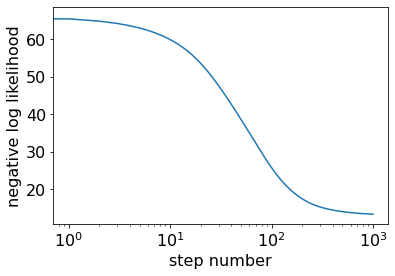

In [128]:
plt.plot(losses)
plt.ylabel("negative log likelihood")
_ = plt.xlabel("step number")
# plt.yscale('log')
plt.xscale('log')

In [129]:
pred = model.apply(params, t, yerr, y, true_t)[1]

plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3, label="truth")
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(true_t, pred, label="max likelihood model")
plt.xlabel("x [day]")
plt.ylabel("y [ppm]")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5)
plt.legend()
_ = plt.title("maximum likelihood")

In [130]:
params

FrozenDict({
    params: {
        log_jitter: DeviceArray(-6.735123, dtype=float32),
        log_rho1: DeviceArray(0.78433704, dtype=float32),
        log_rho2: DeviceArray(1.9860336, dtype=float32),
        log_sigma1: DeviceArray(-0.19724418, dtype=float32),
        log_sigma2: DeviceArray(0.11733528, dtype=float32),
        log_tau: DeviceArray(1.0191799, dtype=float32),
        mean: DeviceArray(-0.04697918, dtype=float32),
    },
})

In [131]:
params['params']['mean']

DeviceArray(-0.04697918, dtype=float32)

In [132]:
def load_fitted_gp(x, yerr, params):
    mean = params['params']['mean']
    log_jitter = params['params']['log_jitter']

    log_sigma1 = params['params']['log_sigma1']
    log_rho1 = params['params']['log_rho1']
    log_tau = params['params']['log_tau']
    kernel1 = (
        jnp.exp(2 * log_sigma1)
        * kernels.ExpSquared(jnp.exp(log_tau))
        * kernels.Cosine(jnp.exp(log_rho1))
    )

    log_sigma2 = params['params']['log_sigma2']
    log_rho2 = params['params']['log_rho2']
    kernel2 = jnp.exp(2 * log_sigma2) * kernels.Matern32(jnp.exp(log_rho2))

    kernel = kernel1 + kernel2
    # kernel = kernel2
    gp = GaussianProcess(
        kernel, x, diag=yerr**2 + jnp.exp(log_jitter), mean=mean
    )

    # log_prob, gp_cond = gp.condition(y, t)
    
    return gp

In [133]:
fitted_gp = load_fitted_gp(t, yerr, params)

In [134]:
t

array([0.16645431, 0.24250557, 0.35787392, 0.4868318 , 0.73962709,
       0.86350714, 1.34719868, 1.40903249, 1.66773807, 1.68497396,
       1.71146656, 1.77353981, 2.10742219, 2.40032472, 2.44668746,
       2.64999851, 2.88073341, 2.89233087, 2.94103298, 2.95785729,
       2.98704436, 3.12649413, 3.14499845, 3.2626721 , 3.39386026,
       3.52170696, 3.68865249, 3.70736494, 6.08464677, 6.19430271,
       6.35262112, 6.52109207, 6.90564989, 6.96621411, 7.16706868,
       7.46718363, 7.61300115, 7.64067217, 8.51416298, 8.57372029,
       8.65119296, 8.8514297 , 9.12143961, 9.24516911, 9.24705188,
       9.8537938 ])

In [135]:
t_test = np.linspace(-10, 20, 1000)

In [136]:
_, gp_cond = fitted_gp.condition(y, t_test)

In [137]:
y_sample = gp_cond.sample(jax.random.PRNGKey(1), shape=(12,))

In [138]:
plt.figure(figsize=(14,6), dpi=100)
plt.plot(t_test, gp_cond.mean, c='C0')
plt.plot(t_test, gp_cond.mean + np.sqrt(gp_cond.variance), c='C1', ls='--')
plt.plot(t_test, gp_cond.mean - np.sqrt(gp_cond.variance), c='C1', ls='--')

plt.plot(t_test, y_sample[0], "C0", lw=0.5, alpha=0.5, label="samples")
plt.plot(t_test, y_sample[1:].T, "C0", lw=0.5, alpha=0.5)

plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
# plt.grid()

<ErrorbarContainer object of 3 artists>

In [139]:
plt.figure(figsize=(14,6), dpi=100)
plt.plot(t_test, gp_cond.mean, c='C0')
plt.plot(t_test, gp_cond.mean + np.sqrt(gp_cond.variance), c='C1', ls='--')
plt.plot(t_test, gp_cond.mean - np.sqrt(gp_cond.variance), c='C1', ls='--')

plt.plot(t_test, y_sample[0], "C0", lw=0.5, alpha=0.5, label="samples")
plt.plot(t_test, y_sample[1:].T, "C0", lw=0.5, alpha=0.5)

plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
# plt.grid()

plt.xlim(0, 10)

(0.0, 10.0)

In [140]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

prior_sigma = 5.0


def numpyro_model(t, yerr, y=None):
    mean = numpyro.sample("mean", dist.Normal(0.0, prior_sigma))
    jitter = numpyro.sample("jitter", dist.HalfNormal(prior_sigma))

    sigma1 = numpyro.sample("sigma1", dist.HalfNormal(prior_sigma))
    rho1 = numpyro.sample("rho1", dist.HalfNormal(prior_sigma))
    tau = numpyro.sample("tau", dist.HalfNormal(prior_sigma))
    kernel1 = sigma1**2 * kernels.ExpSquared(tau) * kernels.Cosine(rho1)

    sigma2 = numpyro.sample("sigma2", dist.HalfNormal(prior_sigma))
    rho2 = numpyro.sample("rho2", dist.HalfNormal(prior_sigma))
    kernel2 = sigma2**2 * kernels.Matern32(rho2)

    kernel = kernel1 + kernel2
    # kernel = kernel2
    gp = GaussianProcess(kernel, t, diag=yerr**2 + jitter, mean=mean)
    numpyro.sample("gp", gp.numpyro_dist(), obs=y)

    if y is not None:
        numpyro.deterministic("pred", gp.condition(y, true_t).gp.loc)


nuts_kernel = NUTS(numpyro_model, dense_mass=True, target_accept_prob=0.9)
mcmc = MCMC(
    nuts_kernel,
    num_warmup=1000,
    num_samples=1000,
    num_chains=2,
    progress_bar=False,
)
rng_key = jax.random.PRNGKey(34923)

/var/folders/mq/kw_39j7d7n39tm1hyxg3sfx40000gn/T/ipykernel_45520/2520941093.py:31: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


In [141]:
%%time
mcmc.run(rng_key, t, yerr, y=y)
samples = mcmc.get_samples()
pred = samples["pred"].block_until_ready()  # Blocking to get timing right

CPU times: user 1min 11s, sys: 32 s, total: 1min 43s
Wall time: 34.7 s


In [142]:
import arviz as az

data = az.from_numpyro(mcmc)
az.summary(
    data, var_names=[v for v in data.posterior.data_vars if v != "pred"]
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
jitter  0.004  0.004   0.000    0.010      0.000    0.000    1134.0     719.0   
mean    0.043  1.703  -3.479    3.265      0.062    0.055     964.0     555.0   
rho1    2.474  0.860   1.846    3.544      0.052    0.037     839.0     226.0   
rho2    7.202  3.088   1.601   12.851      0.098    0.070     776.0     565.0   
sigma1  1.215  0.688   0.434    2.402      0.020    0.014    1426.0    1131.0   
sigma2  1.985  1.171   0.482    4.375      0.045    0.032     671.0     784.0   
tau     3.281  1.759   0.589    6.237      0.064    0.045     646.0     401.0   

        r_hat  
jitter   1.00  
mean     1.00  
rho1     1.01  
rho2     1.00  
sigma1   1.00  
sigma2   1.00  
tau      1.00

In [143]:
q = np.percentile(pred, [5, 50, 95], axis=0)
plt.fill_between(true_t, q[0], q[2], color="C0", alpha=0.5, label="inference")
plt.plot(true_t, q[1], color="C0", lw=2)
plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3, label="truth")

plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("x [day]")
plt.ylabel("y [ppm]")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5)
plt.legend()
_ = plt.title("posterior inference")